In [1]:
import os

from sklearn.metrics import cohen_kappa_score
import itertools

from collections import defaultdict

import re

from typing import Dict, List

import numpy as np
import math

import pandas as pd

import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (15, 10)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'cm'


from tqdm import tqdm

import seaborn as sns
import colorcet as cc
sns.set()
sns.set(font_scale=2)  # crazy big

In [2]:
DATA_PATH = os.path.join('..', 'data_2', 'Keep')

In [3]:
def read_data():
    doc_annotations = {}
    text_lengths = {}

    authors_set = set()

    for author_folder in os.listdir(DATA_PATH):
        authors_set.add(author_folder)
        full_path = os.path.join(DATA_PATH, author_folder)
        ann_files = list(filter(lambda x: x.endswith('.ann'), os.listdir(full_path)))
        for filename in ann_files:
            doc_name = os.path.splitext(filename)[0]
            if doc_name not in doc_annotations.keys():
                doc_annotations[doc_name] = {}

            if author_folder in doc_annotations[doc_name].keys():
                raise Exception(f'Author "{author_folder}" has duplicated annotation for document "{doc_name}"')

            with open(os.path.join(full_path, filename), 'r') as file_handler:
                doc_annotations[doc_name][author_folder] = file_handler.read()

            if doc_name not in text_lengths.keys():
                with open(os.path.join(full_path, f'{doc_name}.txt'), 'r') as txt_file_handler:
                    text_lengths[doc_name] = len(txt_file_handler.read())

    return doc_annotations, text_lengths, list(sorted(authors_set))

In [4]:
doc_annotations, text_lengths, authors_set = read_data()

In [5]:
valid_annotations = {
    k: v for k, v in doc_annotations.items()
    if len(v.keys()) > 1
}

In [6]:
class Annotation:
    def __init__(self, key: str, entity: str, start_pos: int, end_pos: int):
        self.key = key
        self.entity = entity
        self.start_pos = start_pos
        self.end_pos = end_pos

    def __str__(self):
        return f'<{self.key}-{self.entity}-[{self.start_pos}:{self.end_pos}]>'

In [7]:
invalid_labels = ['DuplicatePage', 'TranscriptionError_Document']

class DocumentAnnotation:
    def __init__(self, doc_key: str, annotations_str: str, text_length: int, labels_to_use: List[str]):
        self.doc_key = doc_key
        self.text_length = text_length
        self.is_valid=True

        self.annotations = self._parse_annotations(annotations_str, labels_to_use)

    def _parse_annotations(self, annotations_str: str, labels_to_use: List[str]):
        result = []
        annotations = annotations_str.split('\n')
        for annotation in annotations:
            annotation_parts = annotation.split('\t')
            if not re.search('([T]{1}[0-9]+)', annotation_parts[0]): continue
            if len(annotation_parts) < 2: print(annotation_parts)

            split_annotation = annotation_parts[1].split(' ')
            label = split_annotation[0]

            if label in invalid_labels:
                # self.is_valid=False
                continue

            if label not in labels_to_use:
                continue

            current_annotations_parts = ' '.join(split_annotation[1:]).split(';')

            start = int(current_annotations_parts[0].split(' ')[0])
            end = int(current_annotations_parts[-1].split(' ')[-1])

            result.append(
                Annotation(
                    key=annotation_parts[0],
                    entity=label,
                    start_pos=start,
                    end_pos=end))

        return result

In [8]:
def parse_annotations(valid_annotations, text_lengths: Dict[str, int], labels_to_use: List[str]):
    parsed_annotations = {
        doc_key: {
            author: DocumentAnnotation(doc_key, annotations, text_lengths[doc_key], labels_to_use)
            for author, annotations in annotations_per_author.items()
        }
        for doc_key, annotations_per_author in valid_annotations.items()
    }

    # Remove invalid annotations
    parsed_annotations = {
        doc_key: {
            author: doc_annotation
            for author, doc_annotation in annotations_per_author.items()
            if doc_annotation.is_valid
        }
        for doc_key, annotations_per_author in parsed_annotations.items()
    }

    # Remove documents where we are left with only one annotation
    parsed_annotations = {
        doc_key: annotations_per_author
        for doc_key, annotations_per_author in parsed_annotations.items()
        if len(annotations_per_author.keys()) > 1
    }

    return parsed_annotations

In [9]:
def annotations_overlap(annotation1: Annotation, annotation2: Annotation, offset_chars: int, match_entity: bool) -> bool:
    # if the two annotations do not even overlap with one character, we return false
    if (annotation1.start_pos > annotation2.end_pos or
        annotation1.end_pos < annotation2.start_pos):
        return False

    if match_entity and (annotation1.entity != annotation2.entity):
        return False

    out_of_boundary_chars = abs(annotation1.start_pos - annotation2.start_pos) + abs(annotation1.end_pos - annotation2.end_pos)

    result = out_of_boundary_chars <= offset_chars
    return result

In [10]:
def print_mapped_annotations(mapped_annotations: dict):
    for ann1, ann2 in mapped_annotations.items():
        print(f'{ann1.key} <{ann1.start_pos}-{ann1.end_pos}>  ---', end='')
        if ann2 is None:
            print('NONE')
        else:
            print(f'{ann2.key} <{ann2.start_pos}-{ann2.end_pos}>')

In [11]:
def get_overlapping_annotation(annotation_to_compare: Annotation, annotations: List[Annotation], keys_to_skip: List[str], offset_chars: int, match_entity: bool) -> Annotation:
    overlaps = []
    for annotation2 in annotations:

        if annotation_to_compare.start_pos > annotation2.end_pos:
            continue

        if annotation2.key in keys_to_skip:
            continue

        if annotations_overlap(annotation_to_compare, annotation2, offset_chars, match_entity):
            overlaps.append(annotation2)

    if len(overlaps) == 0:
        return None

    for overlap in overlaps:
        if overlap.entity == annotation_to_compare.entity:
            return overlap

    return overlaps[0]

In [12]:
def calculate_entity_overlap(doc_annotation1: DocumentAnnotation, doc_annotation2: DocumentAnnotation, offset_chars: int, debug: bool = False):
    assert (doc_annotation1.doc_key == doc_annotation2.doc_key)

    mapped_annotations = {}
    used_counter_annotations = set()
    empty_positions = [1 for _ in range(0, doc_annotation1.text_length)]
    for annotation in doc_annotation1.annotations:
        for i in range(annotation.start_pos, annotation.end_pos):
            empty_positions[i] = 0

    # Perform iteration using strict overlap matching
    for annotation in doc_annotation1.annotations:
        overlapping_annotation = get_overlapping_annotation(annotation, doc_annotation2.annotations, used_counter_annotations, offset_chars, match_entity=True)
        if overlapping_annotation is not None:
            used_counter_annotations.add(overlapping_annotation.key)
            mapped_annotations[annotation] = overlapping_annotation

    # Perform iteration using loose overlap matching
    for annotation in doc_annotation1.annotations:
        if annotation in mapped_annotations.keys():
            continue

        overlapping_annotation = get_overlapping_annotation(annotation, doc_annotation2.annotations, used_counter_annotations, offset_chars, match_entity=False)
        if overlapping_annotation is not None:
            used_counter_annotations.add(overlapping_annotation.key)

        mapped_annotations[annotation] = overlapping_annotation

    if debug:
        print_mapped_annotations(mapped_annotations)
    annotation_maps = [ x.entity for x in mapped_annotations.keys() ]
    counter_annotations = [ x.entity if x is not None else 'O' for x in mapped_annotations.values() ]

    for annotation2 in doc_annotation2.annotations:
        for i in range(annotation2.start_pos, annotation2.end_pos):
            empty_positions[i] = 0

        if annotation2.key in used_counter_annotations:
            continue

        annotation_maps.append('O')
        counter_annotations.append(annotation2.entity)

    free_positions = sum(empty_positions)
    for _ in range(free_positions):
        annotation_maps.append('O')
        counter_annotations.append('O')

    if annotation_maps == counter_annotations:
        result = 1
    else:
        result = cohen_kappa_score(annotation_maps, counter_annotations)

    return result

In [13]:
def create_comparison_matrix(parsed_annotations, offset_chars: int, authors_set: set, authors:List[str]=None):
    comparisons = {
        author_1 : {
            author_2: []
            for author_2 in authors_set
        } for author_1 in authors_set
    }

    for _, annotations in parsed_annotations.items():
        for author_1, author_2 in itertools.product(authors_set, authors_set):
            if author_1 in annotations.keys() and author_2 in annotations.keys():
                kappa_score = calculate_entity_overlap(annotations[author_1], annotations[author_2], offset_chars)
                comparisons[author_1][author_2].append(kappa_score)

        for author in authors_set:
            comparisons[author][author] = [1]

    return comparisons

In [14]:
def print_comparison_matrix(comparisons, authors_set: List[str], offset_chars: int, labels_to_use: List[str]):
    print('Result')
    print(f'- offset characters: {offset_chars}')
    print(f'- used labels: {", ".join(labels_to_use)}')
    print('----------------------------------------------')
    print('\t', end='')
    print('\t'.join(authors_set))
    for author_1 in authors_set:
        print(author_1, end='\t')
        for author_2 in authors_set:
            print(round(np.mean(comparisons[author_1][author_2]), 2), end='\t')

        print()

In [26]:
def plot_comparison_lines(values_per_offset, authors_set):
    sns.set_palette(sns.color_palette('husl', 15))
    offset_chars = list(values_per_offset.keys())
    passed_authors = []
    for author1 in authors_set:
        for author2 in authors_set:
            if author1 == author2: continue

            if (author1, author2) in passed_authors or (author2, author1) in passed_authors:
                continue

            y = [np.mean(x[author1][author2]) for x in values_per_offset.values() if author1 in x.keys() and author2 in x[author1].keys()]
            if all(x is None for x in y):
                continue

            label = f'{author1}, {author2}'
            sns.lineplot(x=offset_chars, y=y, label=label)
            passed_authors.append((author1, author2))

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

In [27]:
def plot_confidence_intervals(values_per_offset, authors_set):
    offset_chars = list(values_per_offset.keys())
    y_values = [[] for _ in offset_chars]
    passed_authors = []
    for author1 in authors_set:
        for author2 in authors_set:
            if author1 == author2: continue

            if (author1, author2) in passed_authors or (author2, author1) in passed_authors:
                continue

            label = f'{author1}, {author2}'
            y = [[label, offset, np.mean(x[author1][author2])] for offset, x in values_per_offset.items() if author1 in x.keys() and author2 in x[author1].keys()]
            if all(x is None for x in y): 
                continue

            y_values.extend(y)

    df = pd.DataFrame(y_values,columns=['pairs', 'offsets', 'values'])
    sns.lineplot(data=df, x='offsets', y='values')
    plt.show()

In [17]:
def calculate_comparisons(valid_annotations, text_lengths: Dict[str, int], authors_set: List[str], offset_chars: List[int], labels_to_use: List[str]):
    parsed_annotations = parse_annotations(valid_annotations, text_lengths, labels_to_use)

    values_per_offset = {
        offset_char: create_comparison_matrix(parsed_annotations, offset_char, authors_set)
        for offset_char in tqdm(offset_chars)
    }

    return values_per_offset

In [18]:
offset_chars = list(range(0, 5))

labels_to_use=['Person', 'Place', 'Organization']

In [19]:
values_per_offset = calculate_comparisons(valid_annotations, text_lengths, authors_set, offset_chars=offset_chars, labels_to_use=labels_to_use)

100%|██████████| 5/5 [00:13<00:00,  2.65s/it]


In [20]:
def filter_values(values_per_offset, specific_author: str):
    specific_values_per_offset = {
        offset: {
            author_1: {
                author_2: values
                for author_2, values in values_per_author.items()
                if author_1 == specific_author or author_2 == specific_author
            }
            for author_1, values_per_author in values_per_authors.items()
        }
        for offset, values_per_authors in values_per_offset.items()
    }

    return specific_values_per_offset

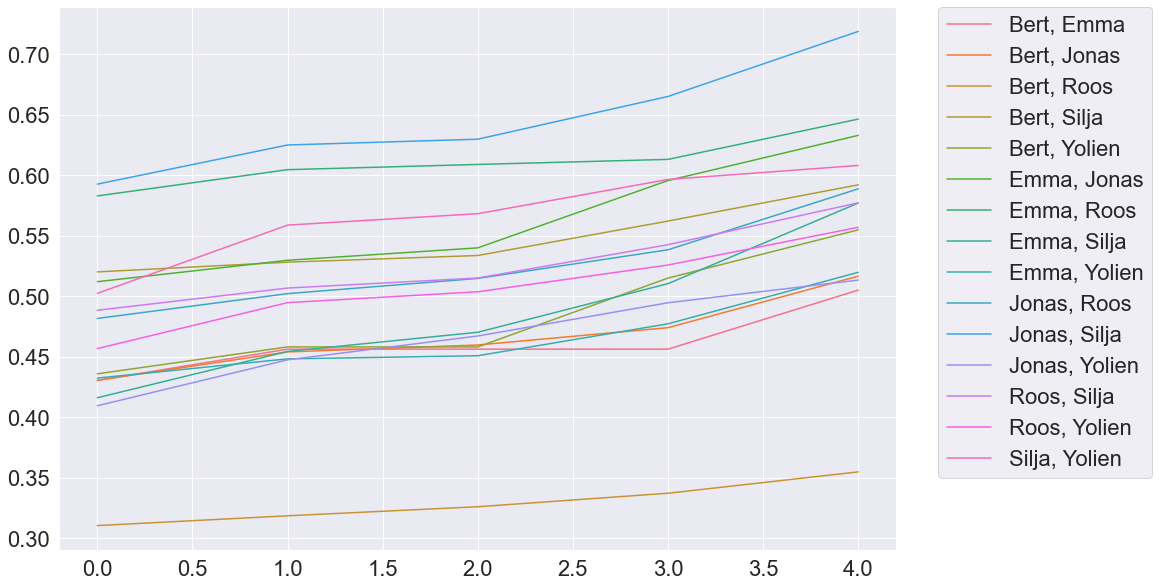

In [21]:
plot_comparison_lines(values_per_offset, authors_set)

In [22]:
bert_values_per_offset = filter_values(values_per_offset, specific_author='Bert')

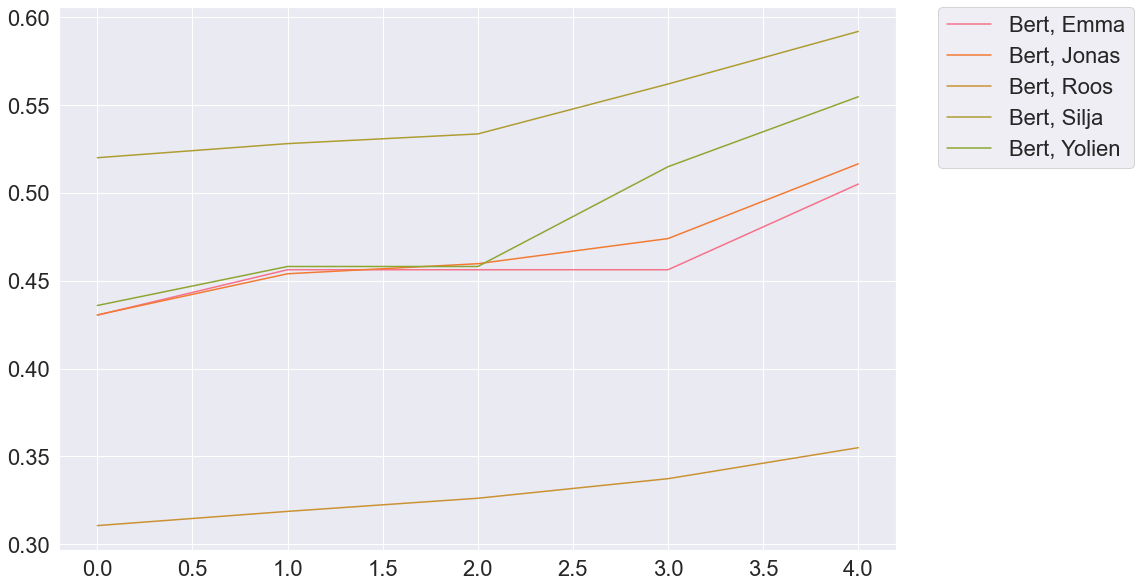

In [28]:
plot_comparison_lines(bert_values_per_offset, authors_set)

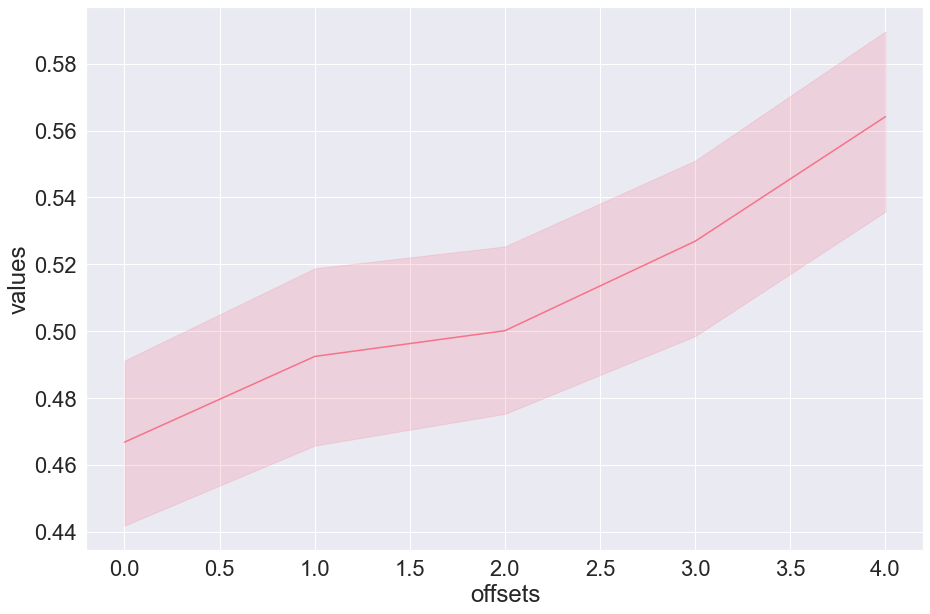

In [24]:
plot_confidence_intervals(values_per_offset, authors_set)

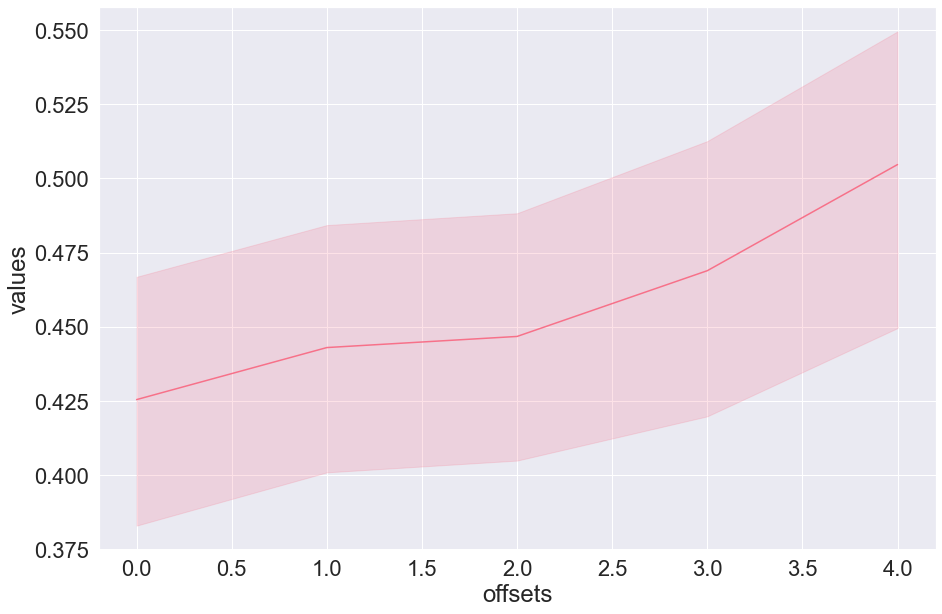

In [29]:
plot_confidence_intervals(bert_values_per_offset, authors_set)